In [8]:
!pip install POT


In [9]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
import time
from tqdm import trange
import itertools
import pandas as pd
import scipy.optimize as opt
import jax.numpy as jnp
import jax
import jaxopt
import optax
import ot
import ot.plot
jax.config.update("jax_enable_x64", True)

First, generate measures

In [43]:
def compute_cost_matrix_quadratic(n, N):
    # Initialize an N-dimensional array of size n in each dimension
    shape = (n,) * N
    C = np.zeros(shape)

    # Set to track already computed indices
    computed_indices = set()

    # Generate all index combinations for the upper triangular part
    for index in itertools.product(*[range(n) for _ in range(N)]):
        sorted_index = tuple(sorted(index))
        if sorted_index in computed_indices:
            continue

        total_cost = 0
        # Compute the sum of (index[i] - index[j])**2 for all unique pairs (i, j)
        for i, j in itertools.combinations(range(N), 2):
            diff = index[i] - index[j]
            total_cost += diff ** 2

        # Assign the computed cost to the corresponding element in the matrix
        C[index] = total_cost

        # Mark the indices as computed
        computed_indices.add(sorted_index)

    # Reflect the upper triangular part to the lower triangular part for all dimensions
    for index in itertools.product(*[range(n) for _ in range(N)]):
        for perm in itertools.permutations(index):
            C[perm] = C[index]

    return C / C.max()

# Example usage
n = 3  # Example dimension size
N = 2 # Example number of dimensions
start_time = time.time()
cost_matrix = compute_cost_matrix_quadratic(n, N)
end_time = time.time()
print("Time taken:", end_time - start_time)
print(cost_matrix)

# Check symmetry
def check_symmetry(C):
    n = C.shape[0]
    N = len(C.shape)

    # Check if C[i, j, k, ...] == C[j, i, k, ...] for all possible permutations
    for index in itertools.product(*[range(n) for _ in range(N)]):
        value = C[index]
        for perm in itertools.permutations(index):
            if not np.isclose(C[perm], value):
                print(f"Symmetry check failed at index {index} and {perm}")
                return False
    return True

is_symmetric = check_symmetry(cost_matrix)
print("Symmetry check:", is_symmetric)


Time taken: 0.00011396408081054688
[[0.   0.25 1.  ]
 [0.25 0.   0.25]
 [1.   0.25 0.  ]]
Symmetry check: True


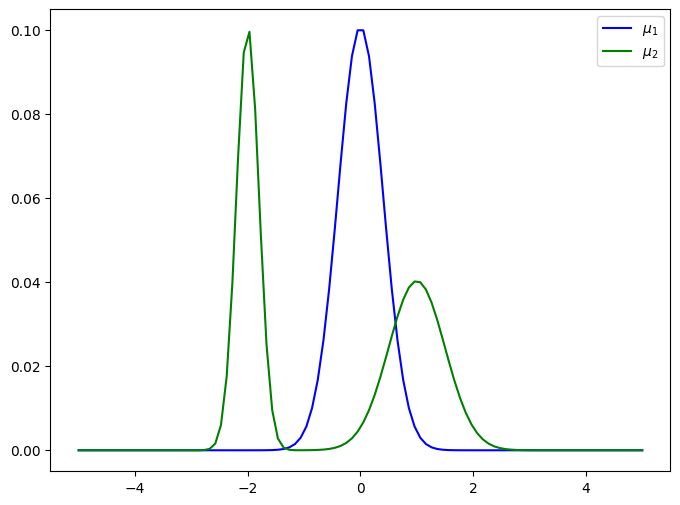

In [44]:
x = jnp.linspace(-5, 5, 100)

mu_1 = norm.pdf(x, loc=0, scale=0.4)
mu_2 = 0.5*norm.pdf(x, loc=-2, scale=0.2) + 0.5*norm.pdf(x, loc=1, scale=0.5)


mu_1 = mu_1 / mu_1.sum()
mu_2 = mu_2 / mu_2.sum()


# Plot the measures
plt.figure(figsize=(8, 6))
plt.plot(x, mu_1, label=r'$\mu_1$', color='blue')
plt.plot(x, mu_2, label=r'$\mu_2$', color='green')

plt.legend()
plt.show()

(array([[1.10517092, 1.22140276, 1.34985881],
        [1.4918247 , 1.64872127, 1.8221188 ],
        [2.01375271, 2.22554093, 2.45960311]]),
 1.6487212707001282)

In [ ]:
def get_all_arguments(vars):
    result = []
    for (j, var) in enumerate(vars): 
        result.append(var)
        result.append([j])
    
    return result

In [ ]:
K = np.array([[1,0.76],[1,1]])
scaling_factors = np.array([[1,15],[1,0.7]])
N = 2
print(np.einsum(K, np.arange(N), *get_all_arguments(scaling_factors)))
# get_all_arguments(scaling_factors)np.sum(K * scaling_factors[0][:, None] * scaling_factors[1][None, :])
reg_term = 
reg_term

27.032


27.032

In [ ]:
def objective(potentials, K, epsilon, marginals):
    scaling_factors = np.exp(potentials/epsilon)

    reg_term = np.sum(K * scaling_factors[0][:, None] * scaling_factors[1][None, :])
    dot_products = sum(p @ m for p, m in zip(potentials, marginals))

    # - concave = convex so we can minimize the negative
    return - (dot_products - epsilon * jnp.log(reg_term))


def get_grad(potentials, K, epsilon, marginals):
    potentials = np.array(potentials)
    scaling_factors = np.exp(potentials/epsilon)

    u, v = potentials
    u, v = np.array(u), np.array(v)

    mu_1, mu_2 = marginals
    u, v = np.array(u), np.array(v)

    reg_term = np.array(K * scaling_factors[0][:, None] * scaling_factors[1][None, :])
    reg_term /= np.sum(reg_term)

    grad_u = -mu_1 + np.sum(reg_term, axis=1)
    grad_v = -mu_2 + np.sum(reg_term, axis=0)

    return np.array([grad_u, grad_v])


def stochastic_marginal(marginals, C, epsilon, lr=1e-4, thr=1e-4, optimizer=optax.sgd, max_iter=20000):
    n = marginals[0].shape[0]

    # entropic regularization
    K = np.array(np.exp((-C) / epsilon), dtype=jnp.float64)
    
    potentials = np.array([np.zeros(n) for _ in range(len(marginals))])

    n = 0

    while n < max_iter:
        n += 1
        grad = get_grad(potentials, K, epsilon, marginals)
        potentials = potentials - lr * grad

        # if n % 1000 == 0:
            # print(objective(potentials, K, epsilon, marginals))

        if np.linalg.norm(grad) < thr:
            return potentials, n, np.linalg.norm(grad)

    return potentials, n

    

In [126]:
eps = 1e-3
tol = 1e-4
lr = 1e-4
max_iter = 20000

quadratic_cost_2m = compute_cost_matrix_quadratic(100, 2)
stochastic_marginal([mu_1, mu_2], quadratic_cost_2m, 1e-4, lr, tol, optax.adam, max_iter=max_iter)

(array([[-5.86576032e-05, -6.81179666e-05, -6.79957732e-05,
         -6.79708511e-05, -6.79718113e-05, -6.79718448e-05,
         -6.79718425e-05, -6.79718425e-05, -6.79718425e-05,
         -6.79718425e-05, -6.79718425e-05, -6.79718425e-05,
         -6.79718425e-05, -6.79718425e-05, -7.40822925e-05,
         -2.13852622e-03, -4.28223289e-03, -6.22866962e-03,
         -8.00903227e-03, -9.67377307e-03, -1.11901708e-02,
         -1.25145850e-02, -1.36366591e-02, -1.45548989e-02,
         -1.52691074e-02, -1.57792596e-02, -1.60853567e-02,
         -1.61874325e-02, -1.60857525e-02, -1.57823226e-02,
         -1.52905986e-02, -1.46594200e-02, -1.39082217e-02,
         -1.29824755e-02, -1.18552145e-02, -1.05189296e-02,
         -8.96827152e-03, -7.19935068e-03, -5.21367824e-03,
         -3.01710756e-03, -6.15282539e-04,  1.98742129e-03,
          4.78349055e-03,  7.74170879e-03,  1.08058660e-02,
          1.39805056e-02,  1.72438567e-02,  2.05621101e-02,
          2.38733256e-02,  2.66687063e-0

In [ ]:
def get_all_arguments(vars):
    result = []
    for (j, var) in enumerate(vars):
        result.append(var)
        result.append([j])

    return result

def stochastic_multimarginal(marginals, C, eps, lr=1e-4, thr=1e-4, optimizer=optax.sgd, max_iter=20000):
    N = len(marginals)
    n = marginals[0].shape[0]

    K = jnp.array(np.exp((-C) / eps), dtype=jnp.float64)

    potentials = [
        jnp.zeros(n) for _ in range(len(marginals))
    ]

    @jax.jit
    def F(potentials):
        potentials_exp = jax.tree.map(lambda x: jnp.exp(x / eps), potentials)
        reg_term = jnp.einsum(K, np.arange(N), *get_all_arguments(potentials_exp))
        dot_products = sum(p @ m for p, m in zip(potentials, marginals))
        return - (dot_products - eps * jnp.log(reg_term))

    get_grad = jax.grad(F)

    def init_sgd(init_potentials, lrate):
        opt = optimizer(learning_rate=lrate)
        state = opt.init(init_potentials)
        return opt, state

    opt, state = init_sgd(potentials, lr)

    @jax.jit
    def sgd_step(potentials, state):
        grad = get_grad(potentials)
        updates, state = opt.update(grad, state, potentials)
        potentials = optax.apply_updates(potentials, updates)
        val = F(potentials)
        return potentials, val, state, grad
    
    val = 0
    i = 0

    for i in trange(max_iter):
        potentials, val, state, grads = sgd_step(potentials, state)
        if True in jax.tree.map(lambda x: jnp.isnan(x).any(), potentials):
            print('Stopped with an error: Nan encountered')
            return

        if max(jax.tree.map(lambda x: jnp.linalg.norm(x), grads)) < thr:
            print(f'''
Algorithm converged successfully on step {i}
Precision {thr} is attained, the value of the min is {-val}
Time taken: {time.time() - start_time} seconds.
                  ''')
            break

        if i == max_iter-1:
            print(f'''
Precision is not attained, algorithm stopped after maximum iterations {max_iter}
Time taken: {time.time() - start_time} seconds.
            ''')

    potentials_exp = [jnp.exp(p / eps) for p in potentials]
    P = jnp.einsum(K, np.arange(N), *get_all_arguments(potentials_exp), np.arange(N))

    log_data = {
        'steps': i,
        'time': time.time() - start_time,
    }

    return P / P.sum(), log_data

In [46]:
eps = 1e-3
tol = 1e-4
lr = 1e-4
max_iter = 20000

In [51]:
quadratic_cost_2m = compute_cost_matrix_quadratic(100, 2)
P, log = stochastic_multimarginal([mu_1, mu_2], quadratic_cost_2m, 1e-4, lr, tol, optax.adam, max_iter=max_iter)

[1.18565539e-35 2.69767896e-34 5.75874067e-33 1.15337425e-31
 2.16729714e-30 3.82095687e-29 6.32020679e-28 9.80834909e-27
 1.42812432e-25 1.95092956e-24 2.50047569e-23 3.00683196e-22
 3.39235390e-21 3.59086123e-20 3.56616608e-19 3.32284422e-18
 2.90485107e-17 2.38255665e-16 1.83344579e-15 1.32372687e-14
 8.96673162e-14 5.69869523e-13 3.39799053e-12 1.90096610e-11
 9.97773700e-11 4.91354805e-10 2.27019852e-09 9.84097068e-09
 4.00237258e-08 1.52722338e-07 5.46755409e-07 1.83649219e-06
 5.78749404e-06 1.71118712e-05 4.74689823e-05 1.23545751e-04
 3.01683238e-04 6.91162268e-04 1.48564257e-03 2.99608495e-03
 5.66890769e-03 1.00635248e-02 1.67612472e-02 2.61919609e-02
 3.84003490e-02 5.28211439e-02 6.81688405e-02 8.25409543e-02
 9.37688388e-02 9.99431571e-02 9.99431571e-02 9.37688388e-02
 8.25409543e-02 6.81688405e-02 5.28211439e-02 3.84003490e-02
 2.61919609e-02 1.67612472e-02 1.00635248e-02 5.66890769e-03
 2.99608495e-03 1.48564257e-03 6.91162268e-04 3.01683238e-04
 1.23545751e-04 4.746898

 17%|█▋        | 3424/20000 [00:00<00:03, 5022.16it/s]



Algorithm converged successfully on step 3424
Precision 0.0001 is attained, the value of the min is 0.01648124058230753
Time taken: 1712.1827960014343 seconds.
                  


In [48]:
def compute_cost_matrix_quadratic_2d(m, n):
    # Initialize an 2-dimensional array of size (m, n)
    shape = (m, n)   
    C = np.zeros(shape)

    # Set to track already computed indices
    computed_indices = set()

    # Generate all index combinations for the upper triangular part
    for index in itertools.product(range(m), range(n)):
        sorted_index = tuple(sorted(index))
        if sorted_index in computed_indices:
            continue
        total_cost = 0
        # Compute the sum of (index[i] - index[j])**2 for all unique pairs (i, j)
        for i, j in [(0, 1), (1, 0)]:
            diff = index[i] - index[j]
            total_cost += diff ** 2

        # Assign the computed cost to the corresponding element in the matrix
        C[index] = total_cost

        # Mark the indices as computed
        computed_indices.add(sorted_index)

    # Reflect the upper triangular part to the lower triangular part for all dimensions
    for index in itertools.product(range(m), range(n)):
        for perm in itertools.permutations(index):
            C[perm] = C[index]

    return C / C.max()

# Example usage
m = 5  # Example dimension size
n = 5 # Example number of dimensions
start_time = time.time()
cost_matrix = compute_cost_matrix_quadratic_2d(m, n)
end_time = time.time()
print("Time taken:", end_time - start_time)
print(cost_matrix)

# Check symmetry
def check_symmetry(C):
    n = C.shape[0]


    # Check if C[i, j, k, ...] == C[j, i, k, ...] for all possible permutations
    for index in itertools.product(*[range(n) for _ in range(2)]):
        value = C[index]
        for perm in itertools.permutations(index):
            if not np.isclose(C[perm], value):
                print(f"Symmetry check failed at index {index} and {perm}")
                return False
    return True

is_symmetric = check_symmetry(cost_matrix)
print("Symmetry check:", is_symmetric)

Time taken: 8.869171142578125e-05
[[0.     0.0625 0.25   0.5625 1.    ]
 [0.0625 0.     0.0625 0.25   0.5625]
 [0.25   0.0625 0.     0.0625 0.25  ]
 [0.5625 0.25   0.0625 0.     0.0625]
 [1.     0.5625 0.25   0.0625 0.    ]]
Symmetry check: True
